In [1]:
from data_loading import *
from data_preprocessing import *
from CNN_model import *
from tensorflow.keras.initializers import HeNormal

import warnings
warnings.filterwarnings('ignore')

2023-06-05 03:44:22.651320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 03:44:22.932787: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-05 03:44:23.065799: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-05 03:44:24.093828: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
import time
import numpy as np

import os
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

# Hyper Parameter Tunning with Keras

In [3]:


early_stopping = EarlyStopping(monitor='val_accuracy', patience=12, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=12, verbose=1, factor=0.1, min_delta=0.001, min_lr=0.00001)

class CNNHyperModel(HyperModel):
    def __init__(self, num_words, embedding_wights):
        self.num_words = num_words
        self.embedding_wights = embedding_wights

    def build(self, hp):
        cnn_model = Sequential()
        cnn_model.add(Embedding(input_dim=self.num_words, output_dim=100, trainable=True, input_length=10, weights=[self.embedding_wights]))
        cnn_model.add(Conv1D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                             kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
                             padding='same', activation='relu'))
        cnn_model.add(MaxPooling1D(pool_size=2))
        cnn_model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        cnn_model.add(Conv1D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
                             kernel_size=hp.Choice('conv_2_kernel', values=[3,5]),
                             padding='same', activation='relu'))
        cnn_model.add(MaxPooling1D(pool_size=2))
        cnn_model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        cnn_model.add(Flatten())
        cnn_model.add(Dense(256, activation='relu'))
        cnn_model.add(Dense(10, activation='softmax'))
        cnn_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)), metrics=['accuracy'])
        return cnn_model

hypermodel = CNNHyperModel(num_words=num_words, embedding_wights=embedding_wights)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='random_search',
    project_name='cnn_model')

tuner.search_space_summary()

tuner.search(x=train_data, y=train_classes, epochs=50, validation_data=(val_data, val_classes), callbacks=[reduce_lr, early_stopping])

tuner.results_summary()


INFO:tensorflow:Reloading Tuner from random_search/cnn_model/tuner0.json
Search space summary
Default search space size: 7
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
INFO:tensorflow:Oracle triggered exit
Results summary
Results

In [14]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


In [15]:
# Open a file in write mode
with open('best_hyperparameters.txt', 'w') as f:
    # Write the hyperparameters to the file
    f.write('The optimal number of filters in the first convolutional layer is: {}\n'.format(best_hps.get('conv_1_filter')))
    f.write('The optimal kernel size in the first convolutional layer is: {}\n'.format(best_hps.get('conv_1_kernel')))
    f.write('The optimal dropout rate after the first convolutional layer is: {}\n'.format(best_hps.get('dropout_1')))
    f.write('The optimal number of filters in the second convolutional layer is: {}\n'.format(best_hps.get('conv_2_filter')))
    f.write('The optimal kernel size in the second convolutional layer is: {}\n'.format(best_hps.get('conv_2_kernel')))
    f.write('The optimal dropout rate after the second convolutional layer is: {}\n'.format(best_hps.get('dropout_2')))
    f.write('The optimal learning rate for the optimizer is: {}\n'.format(best_hps.get('learning_rate')))



In [6]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps

In [14]:
import pickle

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Save the best hyperparameters to a pickle file
with open('best_hyperparameters.pkl', 'wb') as f:
    pickle.dump(best_hps, f)


In [15]:
with open('best_hyperparameters.pkl', 'rb') as f:
    best_hps = pickle.load(f)


In [4]:

import ast

best_hps = {}

with open('best_hyperparameters.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        # Split the line at the colon
        key, value = line.split(':')
        # Remove unnecessary characters and convert to the appropriate type
        key = key.strip().lower().replace('the optimal ', '').replace(' for the optimizer', '').replace(' ', '_')
        value = float(value.strip())
        best_hps[key] = value

In [5]:
best_hps

{'number_of_filters_in_the_first_convolutional_layer_is': 112.0,
 'kernel_size_in_the_first_convolutional_layer_is': 3.0,
 'dropout_rate_after_the_first_convolutional_layer_is': 0.15000000000000002,
 'number_of_filters_in_the_second_convolutional_layer_is': 80.0,
 'kernel_size_in_the_second_convolutional_layer_is': 3.0,
 'dropout_rate_after_the_second_convolutional_layer_is': 0.45,
 'learning_rate_is': 0.00043230060320522735}

In [7]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
%%time


# Initialize lists to store the loss values
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
import tensorflow as tf

# Initialize lists to store the loss values
train_loss = []
val_loss = []
train_acc = []
val_acc = []

from tensorflow.keras.initializers import HeNormal

# Build the model with the optimal hyperparameters
def build_model(hp):
    cnn_model = Sequential()
    cnn_model.add(Embedding(input_dim=num_words, output_dim=100, trainable=True, input_length=10, weights=[embedding_wights]))
    cnn_model.add(Conv1D(filters=int(hp['number_of_filters_in_the_first_convolutional_layer_is']), 
                         kernel_size=int(hp['kernel_size_in_the_first_convolutional_layer_is']), 
                         padding='same', 
                         activation='relu', 
                         kernel_initializer=HeNormal()))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dropout(rate=hp['dropout_rate_after_the_first_convolutional_layer_is']))
    cnn_model.add(Conv1D(filters=int(hp['number_of_filters_in_the_second_convolutional_layer_is']), 
                         kernel_size=int(hp['kernel_size_in_the_second_convolutional_layer_is']), 
                         padding='same', 
                         activation='relu', 
                         kernel_initializer=HeNormal()))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dropout(rate=hp['dropout_rate_after_the_second_convolutional_layer_is']))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(256, activation='relu', kernel_initializer=HeNormal()))
    cnn_model.add(Dense(10, activation='softmax', kernel_initializer=HeNormal()))
    cnn_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(hp['learning_rate_is']), metrics=['accuracy'])
    return cnn_model

cnn_model = build_model(best_hps)


# Define the checkpoint path and filenames
checkpoint_path = "training_checkpoints/cnn-cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')

# Add cp_callback to your callbacks list
callbacks_list = [reduce_lr, early_stopping, cp_callback]

# Train the model for 10 epochs
with tf.device('/GPU:0'):
    history_CNN = cnn_model.fit(x=train_data, y=train_classes, epochs=50,
                        batch_size=2048, shuffle=True,
                        validation_data=(val_data, val_classes),
                        callbacks=callbacks_list,
                        )


Epoch 1/50
102/103 [============================>.] - ETA: 0s - loss: 2.0397 - accuracy: 0.2927
Epoch 1: val_accuracy improved from -inf to 0.52278, saving model to training_checkpoints/cnn-cp-0001.ckpt


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0001.ckpt/assets


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0001.ckpt/assets


103/103 [==============================] - 11s 25ms/step - loss: 2.0373 - accuracy: 0.2936 - val_loss: 1.4772 - val_accuracy: 0.5228 - lr: 4.3230e-04
Epoch 2/50
101/103 [============================>.] - ETA: 0s - loss: 1.4963 - accuracy: 0.5101
Epoch 2: val_accuracy improved from 0.52278 to 0.57680, saving model to training_checkpoints/cnn-cp-0002.ckpt


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0002.ckpt/assets


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0002.ckpt/assets


103/103 [==============================] - 2s 20ms/step - loss: 1.4959 - accuracy: 0.5103 - val_loss: 1.3229 - val_accuracy: 0.5768 - lr: 4.3230e-04
Epoch 3/50
 99/103 [===========================>..] - ETA: 0s - loss: 1.3695 - accuracy: 0.5625
Epoch 3: val_accuracy improved from 0.57680 to 0.59700, saving model to training_checkpoints/cnn-cp-0003.ckpt


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0003.ckpt/assets


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0003.ckpt/assets


103/103 [==============================] - 2s 22ms/step - loss: 1.3696 - accuracy: 0.5625 - val_loss: 1.2615 - val_accuracy: 0.5970 - lr: 4.3230e-04
Epoch 4/50
101/103 [============================>.] - ETA: 0s - loss: 1.2988 - accuracy: 0.5876
Epoch 4: val_accuracy improved from 0.59700 to 0.60907, saving model to training_checkpoints/cnn-cp-0004.ckpt


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0004.ckpt/assets


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0004.ckpt/assets


103/103 [==============================] - 2s 21ms/step - loss: 1.2988 - accuracy: 0.5876 - val_loss: 1.2225 - val_accuracy: 0.6091 - lr: 4.3230e-04
Epoch 5/50
100/103 [============================>.] - ETA: 0s - loss: 1.2514 - accuracy: 0.6044
Epoch 5: val_accuracy improved from 0.60907 to 0.61936, saving model to training_checkpoints/cnn-cp-0005.ckpt


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0005.ckpt/assets


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0005.ckpt/assets


103/103 [==============================] - 11s 107ms/step - loss: 1.2513 - accuracy: 0.6044 - val_loss: 1.1967 - val_accuracy: 0.6194 - lr: 4.3230e-04
Epoch 6/50
103/103 [==============================] - ETA: 0s - loss: 1.2093 - accuracy: 0.6188
Epoch 6: val_accuracy improved from 0.61936 to 0.62600, saving model to training_checkpoints/cnn-cp-0006.ckpt


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0006.ckpt/assets


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0006.ckpt/assets


103/103 [==============================] - 3s 24ms/step - loss: 1.2093 - accuracy: 0.6188 - val_loss: 1.1758 - val_accuracy: 0.6260 - lr: 4.3230e-04
Epoch 7/50
 99/103 [===========================>..] - ETA: 0s - loss: 1.1771 - accuracy: 0.6287
Epoch 7: val_accuracy improved from 0.62600 to 0.62998, saving model to training_checkpoints/cnn-cp-0007.ckpt


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0007.ckpt/assets


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0007.ckpt/assets


103/103 [==============================] - 3s 25ms/step - loss: 1.1771 - accuracy: 0.6290 - val_loss: 1.1613 - val_accuracy: 0.6300 - lr: 4.3230e-04
Epoch 8/50
101/103 [============================>.] - ETA: 0s - loss: 1.1481 - accuracy: 0.6385
Epoch 8: val_accuracy improved from 0.62998 to 0.63380, saving model to training_checkpoints/cnn-cp-0008.ckpt


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0008.ckpt/assets


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0008.ckpt/assets


103/103 [==============================] - 2s 22ms/step - loss: 1.1480 - accuracy: 0.6386 - val_loss: 1.1498 - val_accuracy: 0.6338 - lr: 4.3230e-04
Epoch 9/50
103/103 [==============================] - ETA: 0s - loss: 1.1216 - accuracy: 0.6475
Epoch 9: val_accuracy improved from 0.63380 to 0.63756, saving model to training_checkpoints/cnn-cp-0009.ckpt


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0009.ckpt/assets


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0009.ckpt/assets


103/103 [==============================] - 2s 23ms/step - loss: 1.1216 - accuracy: 0.6475 - val_loss: 1.1396 - val_accuracy: 0.6376 - lr: 4.3230e-04
Epoch 10/50
103/103 [==============================] - ETA: 0s - loss: 1.0965 - accuracy: 0.6558
Epoch 10: val_accuracy improved from 0.63756 to 0.63918, saving model to training_checkpoints/cnn-cp-0010.ckpt


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0010.ckpt/assets


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0010.ckpt/assets


103/103 [==============================] - 9s 93ms/step - loss: 1.0965 - accuracy: 0.6558 - val_loss: 1.1310 - val_accuracy: 0.6392 - lr: 4.3230e-04
Epoch 11/50
 98/103 [===========================>..] - ETA: 0s - loss: 1.0750 - accuracy: 0.6619
Epoch 11: val_accuracy improved from 0.63918 to 0.64184, saving model to training_checkpoints/cnn-cp-0011.ckpt


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0011.ckpt/assets


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0011.ckpt/assets


103/103 [==============================] - 3s 26ms/step - loss: 1.0741 - accuracy: 0.6623 - val_loss: 1.1266 - val_accuracy: 0.6418 - lr: 4.3230e-04
Epoch 12/50
101/103 [============================>.] - ETA: 0s - loss: 1.0517 - accuracy: 0.6697
Epoch 12: val_accuracy improved from 0.64184 to 0.64376, saving model to training_checkpoints/cnn-cp-0012.ckpt


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0012.ckpt/assets


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0012.ckpt/assets


103/103 [==============================] - 12s 116ms/step - loss: 1.0519 - accuracy: 0.6697 - val_loss: 1.1210 - val_accuracy: 0.6438 - lr: 4.3230e-04
Epoch 13/50
100/103 [============================>.] - ETA: 0s - loss: 1.0303 - accuracy: 0.6762
Epoch 13: val_accuracy improved from 0.64376 to 0.64484, saving model to training_checkpoints/cnn-cp-0013.ckpt


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0013.ckpt/assets


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0013.ckpt/assets


103/103 [==============================] - 24s 230ms/step - loss: 1.0299 - accuracy: 0.6763 - val_loss: 1.1196 - val_accuracy: 0.6448 - lr: 4.3230e-04
Epoch 14/50
101/103 [============================>.] - ETA: 0s - loss: 1.0084 - accuracy: 0.6828
Epoch 14: val_accuracy improved from 0.64484 to 0.64711, saving model to training_checkpoints/cnn-cp-0014.ckpt


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0014.ckpt/assets


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0014.ckpt/assets


103/103 [==============================] - 2s 22ms/step - loss: 1.0087 - accuracy: 0.6827 - val_loss: 1.1158 - val_accuracy: 0.6471 - lr: 4.3230e-04
Epoch 15/50
101/103 [============================>.] - ETA: 0s - loss: 0.9889 - accuracy: 0.6897
Epoch 15: val_accuracy did not improve from 0.64711
103/103 [==============================] - 1s 11ms/step - loss: 0.9890 - accuracy: 0.6897 - val_loss: 1.1159 - val_accuracy: 0.6465 - lr: 4.3230e-04
Epoch 16/50
101/103 [============================>.] - ETA: 0s - loss: 0.9696 - accuracy: 0.6962
Epoch 16: val_accuracy improved from 0.64711 to 0.64762, saving model to training_checkpoints/cnn-cp-0016.ckpt


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0016.ckpt/assets


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0016.ckpt/assets


103/103 [==============================] - 2s 22ms/step - loss: 0.9695 - accuracy: 0.6963 - val_loss: 1.1159 - val_accuracy: 0.6476 - lr: 4.3230e-04
Epoch 17/50
100/103 [============================>.] - ETA: 0s - loss: 0.9504 - accuracy: 0.7018
Epoch 17: val_accuracy improved from 0.64762 to 0.64829, saving model to training_checkpoints/cnn-cp-0017.ckpt


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0017.ckpt/assets


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0017.ckpt/assets


103/103 [==============================] - 2s 20ms/step - loss: 0.9505 - accuracy: 0.7016 - val_loss: 1.1211 - val_accuracy: 0.6483 - lr: 4.3230e-04
Epoch 18/50
102/103 [============================>.] - ETA: 0s - loss: 0.9331 - accuracy: 0.7071
Epoch 18: val_accuracy did not improve from 0.64829
103/103 [==============================] - 1s 11ms/step - loss: 0.9331 - accuracy: 0.7070 - val_loss: 1.1224 - val_accuracy: 0.6478 - lr: 4.3230e-04
Epoch 19/50
101/103 [============================>.] - ETA: 0s - loss: 0.9121 - accuracy: 0.7127
Epoch 19: val_accuracy did not improve from 0.64829
103/103 [==============================] - 1s 11ms/step - loss: 0.9121 - accuracy: 0.7128 - val_loss: 1.1265 - val_accuracy: 0.6482 - lr: 4.3230e-04
Epoch 20/50
103/103 [==============================] - ETA: 0s - loss: 0.8957 - accuracy: 0.7184
Epoch 20: val_accuracy improved from 0.64829 to 0.64920, saving model to training_checkpoints/cnn-cp-0020.ckpt


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0020.ckpt/assets


INFO:tensorflow:Assets written to: training_checkpoints/cnn-cp-0020.ckpt/assets


103/103 [==============================] - 2s 21ms/step - loss: 0.8957 - accuracy: 0.7184 - val_loss: 1.1343 - val_accuracy: 0.6492 - lr: 4.3230e-04
Epoch 21/50
100/103 [============================>.] - ETA: 0s - loss: 0.8755 - accuracy: 0.7242
Epoch 21: val_accuracy did not improve from 0.64920
103/103 [==============================] - 1s 11ms/step - loss: 0.8754 - accuracy: 0.7242 - val_loss: 1.1434 - val_accuracy: 0.6472 - lr: 4.3230e-04
Epoch 22/50
102/103 [============================>.] - ETA: 0s - loss: 0.8582 - accuracy: 0.7307
Epoch 22: val_accuracy did not improve from 0.64920
103/103 [==============================] - 1s 10ms/step - loss: 0.8582 - accuracy: 0.7307 - val_loss: 1.1481 - val_accuracy: 0.6472 - lr: 4.3230e-04
Epoch 23/50
103/103 [==============================] - ETA: 0s - loss: 0.8415 - accuracy: 0.7354
Epoch 23: val_accuracy did not improve from 0.64920
103/103 [==============================] - 1s 11ms/step - loss: 0.8415 - accuracy: 0.7354 - val_loss: 1.16

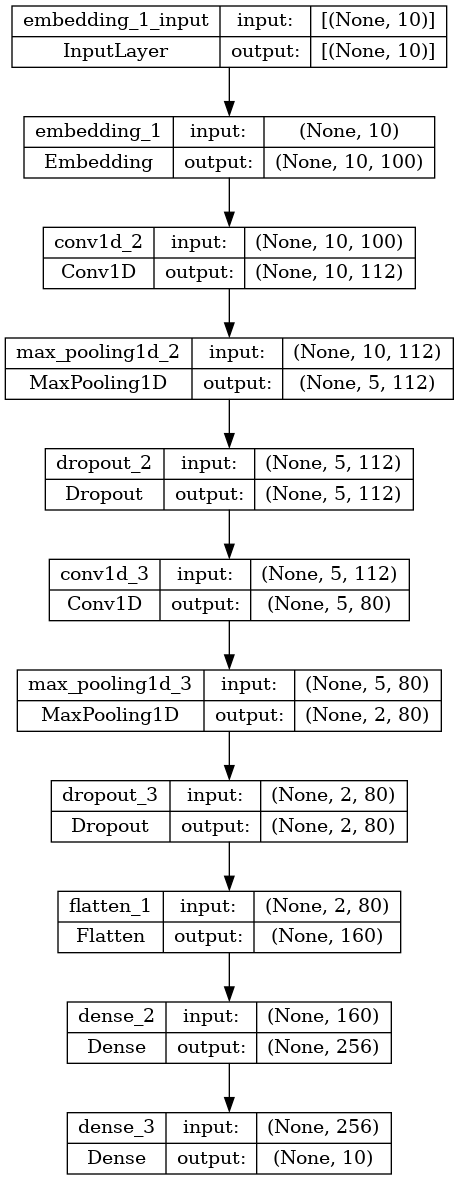

In [21]:
from keras.utils.vis_utils import plot_model
# plot the model diagram
plot_model(cnn_model, to_file='CNN_model_diagram.png', show_shapes=True, show_layer_names=True)

In [22]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 100)           10214800  
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 112)           33712     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5, 112)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 5, 112)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 5, 80)             26960     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2, 80)            0         
 1D)                                                  

In [ ]:
# Append the loss values to the lists
train_loss = history_CNN.history['loss']
val_loss = history_CNN.history['val_loss']
train_acc = history_CNN.history['accuracy']
val_acc = history_CNN.history['val_accuracy']

# Save loss to txt files
if not os.path.exists('loss_cnn'):
    os.makedirs('loss_cnn')
np.savetxt('Epoch_history/train_loss_cnn.txt', train_loss, delimiter=',')
np.savetxt('Epoch_history/val_loss_cnn.txt', val_loss, delimiter=',')
np.savetxt('Epoch_history/train_acc_cnn.txt', train_acc, delimiter=',')
np.savetxt('Epoch_history/val_acc_cnn.txt', val_acc, delimiter=',')


In [6]:
import matplotlib.pyplot as plt

train_loss = np.loadtxt('Epoch_history/train_loss_cnn.txt', delimiter=',')
val_loss = np.loadtxt('Epoch_history/val_loss_cnn.txt', delimiter=',')


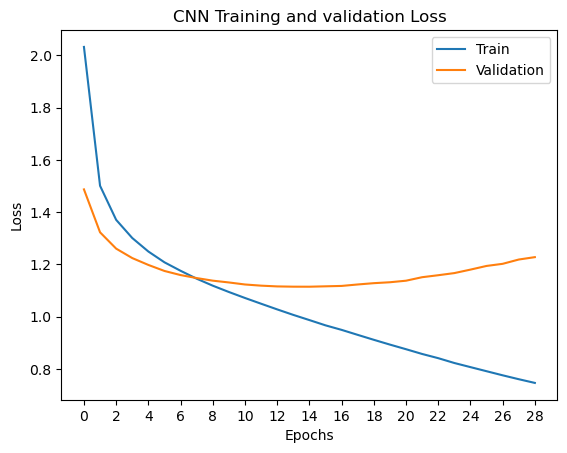

In [7]:
import matplotlib.pyplot as plt

#epochs = range(0,len(history_CNN.history['accuracy']),5)
epochs = range(0,29,2)

# plt.plot(history_CNN.history['accuracy'], label='Training accuracy')
# plt.plot(history_CNN.history['val_accuracy'], label='Validation accuracy')

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('CNN Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.grid()
plt.xticks(epochs)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()



In [8]:
train_acc = np.loadtxt('Epoch_history/train_acc_cnn.txt', delimiter=',')
val_acc = np.loadtxt('Epoch_history/val_acc_cnn.txt', delimiter=',')

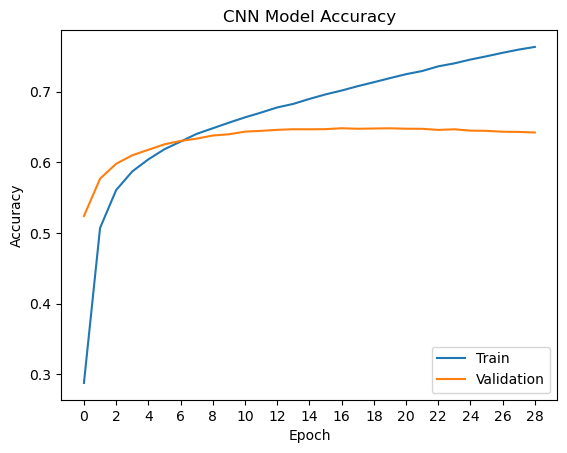

In [9]:
epochs = range(0,29,2)



# plt.plot(history_CNN.history['accuracy'])
# plt.plot(history_CNN.history['val_accuracy'])
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.grid()
plt.xticks(epochs)

plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

## Test

In [30]:
# from tensorflow.keras.models import load_model

# # If previous model exists, load it
# if os.path.exists('save/CNN_model_40.h5'):
#     cnn_model= load_model('save/CNN_model_40.h5')

In [8]:
test_data = test_data
test_labels = test_classes

In [12]:
import tensorflow as tf

# Load the model from the checkpoint file
checkpoint_path = 'training_checkpoints/cnn-cp-0017.ckpt'
loaded_model = tf.keras.models.load_model(checkpoint_path)

# Use the loaded model for prediction or further evaluation
predictions = loaded_model.predict(test_data)


1407/1407 [==============================] - 2s 2ms/step


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from prettytable import PrettyTable




class_names = ['Society & Culture', 'Science & Mathematics', 'Health', 'Education & Reference', 'Computers & Internet',
               'Sports', 'Business & Finance', 'Entertainment & Music', 'Family & Relationships', 'Politics & Government']


# Predict the probabilities for each class
y_pred = predictions

# Calculate the ROC curves and AUC for each class
num_classes = test_labels.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Create a table of ROC curves for each class
table = PrettyTable()
table.field_names = ['Class', 'AUC', 'TPR at FPR = 0.01', 'TPR at FPR = 0.05', 'TPR at FPR = 0.1']
for i in range(num_classes):
    tpr_01 = np.interp(0.01, fpr[i], tpr[i])
    tpr_05 = np.interp(0.05, fpr[i], tpr[i])
    tpr_10 = np.interp(0.1, fpr[i], tpr[i])
    class_name = class_names[i]
    table.add_row([class_name, round( roc_auc[i],2), round(tpr_01,2), round(tpr_05,2), round(tpr_10,2)])
print(table)

+------------------------+------+-------------------+-------------------+------------------+
|         Class          | AUC  | TPR at FPR = 0.01 | TPR at FPR = 0.05 | TPR at FPR = 0.1 |
+------------------------+------+-------------------+-------------------+------------------+
|   Society & Culture    | 0.82 |        0.29       |        0.48       |       0.56       |
| Science & Mathematics  | 0.97 |        0.67       |        0.88       |       0.92       |
|         Health         | 0.84 |        0.23       |        0.46       |       0.58       |
| Education & Reference  | 0.91 |        0.47       |        0.68       |       0.76       |
|  Computers & Internet  | 0.93 |        0.35       |        0.69       |       0.81       |
|         Sports         | 0.94 |        0.5        |        0.76       |       0.84       |
|   Business & Finance   | 0.94 |        0.5        |        0.75       |       0.84       |
| Entertainment & Music  | 0.92 |        0.35       |        0.68     

In [34]:
from sklearn.metrics import classification_report
target_names = class_names
y_true = np.argmax(test_labels, axis=1) 
y_pred = np.argmax(y_pred, axis=1) 
print(classification_report(y_true=y_true,y_pred= y_pred, target_names=target_names))

                        precision    recall  f1-score   support

     Society & Culture       0.58      0.42      0.49      4500
 Science & Mathematics       0.77      0.81      0.79      4500
                Health       0.52      0.42      0.47      4500
 Education & Reference       0.65      0.63      0.64      4500
  Computers & Internet       0.56      0.74      0.63      4500
                Sports       0.67      0.71      0.69      4500
    Business & Finance       0.68      0.70      0.69      4500
 Entertainment & Music       0.63      0.64      0.63      4500
Family & Relationships       0.54      0.52      0.53      4500
 Politics & Government       0.80      0.82      0.81      4500

              accuracy                           0.64     45000
             macro avg       0.64      0.64      0.64     45000
          weighted avg       0.64      0.64      0.64     45000



In [35]:
res = classification_report(y_true=y_true,y_pred= y_pred, target_names=target_names)

In [36]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro')

0.6376362351258352

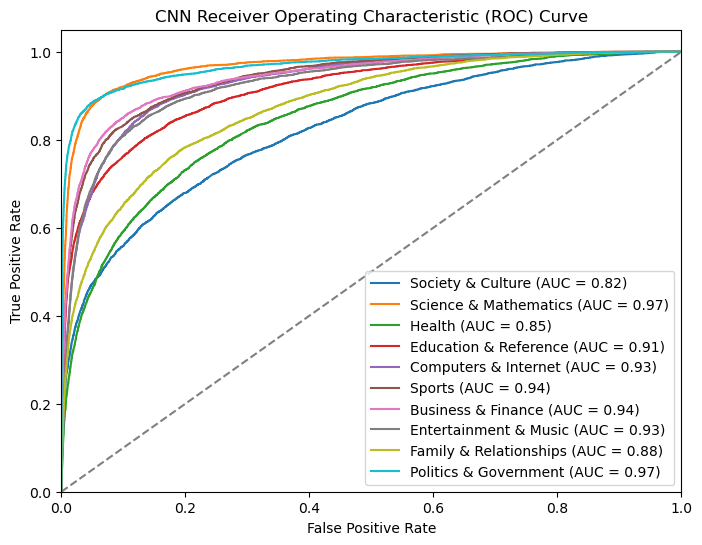

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl

mpl.rcParams['font.size'] = 10




# Make predictions on the test set
predictions = predictions

# Convert the labels to categorical format
test_labels_cat = test_labels

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_cat[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(class_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [38]:
from sklearn.metrics import roc_auc_score
y_pred = predictions
score = roc_auc_score(test_labels, y_pred)
print("\n ROC-AUC score: %.6f \n" % (score))


 ROC-AUC score: 0.910218 



1407/1407 [==============================] - 2s 1ms/step


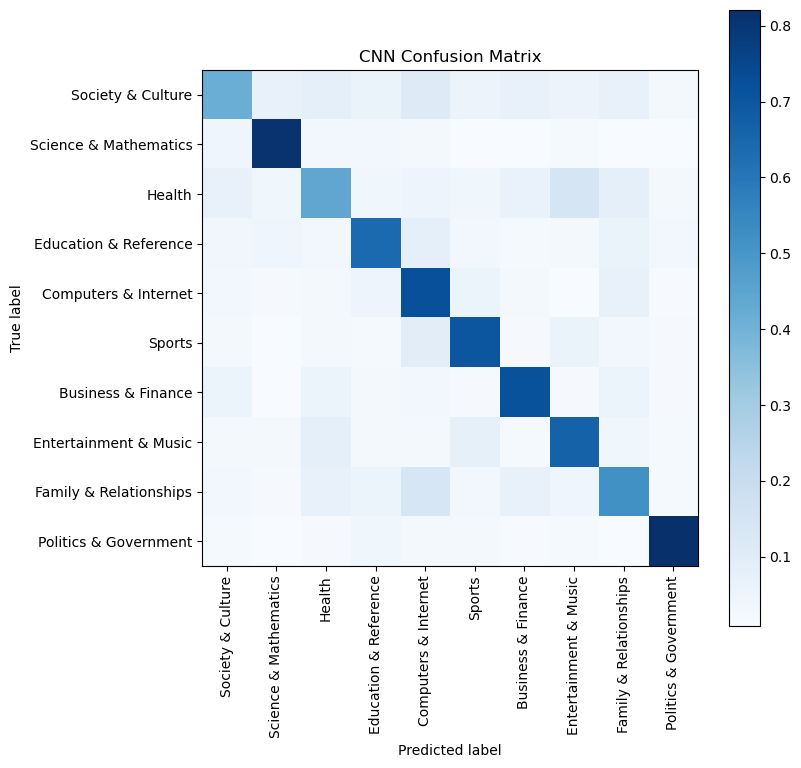

Accuracy: 0.6442888888888889


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the class labels
class_names = ['Society & Culture', 'Science & Mathematics', 'Health', 'Education & Reference', 'Computers & Internet',
               'Sports', 'Business & Finance', 'Entertainment & Music', 'Family & Relationships', 'Politics & Government']

# Make predictions on the test set
predictions = cnn_model.predict(test_data)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1), normalize='true')

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, cmap=plt.cm.Blues)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels and title
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('CNN Confusion Matrix')

# Add category labels
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

# Show the plot
plt.show()

# Calculate and print the accuracy
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(test_labels, axis=1)) / len(np.argmax(test_labels, axis=1))
print('Accuracy:', accuracy)
